# Gram continuation algorithm

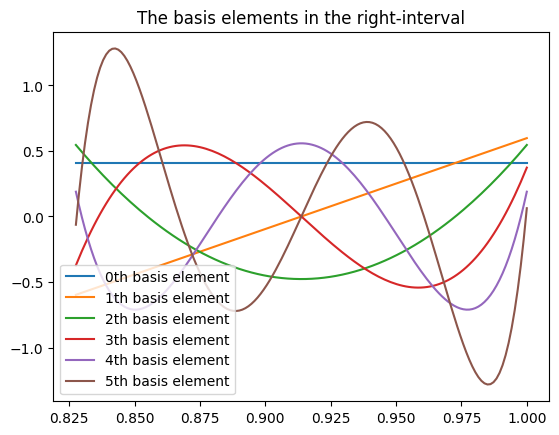

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 64
eps = 1e-64

class GramSchmidt:
    def __init__(self, x, m):
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element].T * A 
        
        return ei
    
    def sp(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs
    
    def reconstructFunction(self, coeffs, x = None): 
        if x == None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    self.A[i] = x[j]**i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debugInformation(self):
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()



        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")

M_ALL_K  = 0 
M_EVEN_K = 1
M_ODD_K  = 2 


def t(g, mode = M_ALL_K):
    if g % 2 == 0:
        k = np.arange(-int(-g/2) + 1, int(g/2) + 1)
    else:
        k = np.arange(-int((g-1)/2), int((g-1)/2) + 1)

    if mode == M_EVEN_K:
        k = k[k % 2 == 0]
    elif mode == M_ODD_K:
        k = k[k % 2 == 1]

    return k * mp.mpf(1)
    
def getX(Delta, Gamma):
    dxeval = Delta/(Gamma - 1) 
    xeval  = mp.matrix(1, Gamma) 
    for i in range(Gamma): 
        xeval[0, i] = 1 - Delta + i * dxeval
    return xeval

def getM(g, Gamma, Delta, d, mode): 
    ks = t(g, mode)
    x  = getX(Delta, Gamma) 
    M  = mp.matrix(Gamma, len(ks))
    for i in range(Gamma):
        for j, k in enumerate(ks):
            M[i, j] = mp.exp(1j * k * np.pi / (d + Delta) * x[0, i])
    return M

def invertComplexM(M, cutoff):
    U, s, Vh = mp.svd(M)
    sinv = mp.diag(s) 
    r = M.cols
    if M.rows < M.cols:
        r = M.rows
    for i in range(r):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]

    Vht = Vh.transpose_conj()
    Ut  = U.transpose_conj()
    f1  = sinv * Ut
    f2  = Vht * f1 
    return  f2

def reconstruct(x, a, g, Gamma, Delta, d, mode): 
    ks = t(g, mode)
    rec = mp.matrix(1, len(x)) 
    for j, coeff in enumerate(a): 
        for i in range(len(x)): 
            rec[i] += coeff * mp.exp(1j * ks[j] * np.pi / (d + Delta) * x[i])
    return rec


def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 1000):
    a       = Minv * f.T
    r       = M * a - f.T
    counter = 0
    while mp.norm(r) > 2 * eps * mp.norm(a) and counter < maxiter: 
        delta    = Minv * r
        a        = a - delta 
        r        = M * a - f.T
        counter += 1
    return a

def computeExtension(x, g, Gamma, Delta, d, mode, f, threshold = 10, maxiter = 10):
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0) 
    a     = iterativeRefinement(M, Minv, f) 
    frec  = reconstruct(x, a, g, Gamma, Delta, d, mode)
    return frec

for m in [6, 8, 10, 12, 14]: 

    #### DEFAULT PARAMS
    # m      = 10
    # n      = 10 
    # nDelta = 10 
    # nd     = 27
    # Gamma  = 150
    # g      = 63
    ####################
    m      = m
    nDelta = m
    nd     = 30
    Gamma  = 150
    g      = 63

    h      = 1/(nd - 1) 
    d      = (nd - 1) * h 
    Delta  = (nDelta  - 1) * h 

    x = mp.linspace(0, 1, nd)

    leftBoundary  = x[       :nDelta]
    rightBoundary = x[-nDelta:      ]

    lgs = GramSchmidt(leftBoundary, m)
    rgs = GramSchmidt(rightBoundary, m)

    dxeval = Delta/(Gamma - 1) 
    xeval  = mp.matrix(1, Gamma) 
    for i in range(Gamma): 
        xeval[0, i] = 1 - Delta + i * dxeval

    plt.title("The basis elements in the right-interval")
    for i in range(m): 
        yeval = rgs.evaluateBasis(xeval, i)
        plt.plot(xeval, yeval, label=f"{i}th basis element") 
    plt.legend()
    plt.show()

    xext  = mp.linspace(1 - Delta, 1 + Delta + 2*d, 1000) 
    mode = M_EVEN_K
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0)
    evencoeffs = []
    evenbasis = []
    evenfrecs = []
    for i in range(m): 
        yeval = rgs.evaluateBasis(xeval, i)
        a     = iterativeRefinement(M, Minv, yeval) 
        frec  = reconstruct(xext, a, g, Gamma, Delta, d, mode)
        evencoeffs.append(a) 
        evenbasis.append(yeval)
        evenfrecs.append(frec)


    mode = M_ODD_K
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0)
    oddcoeffs = []
    oddbasis = []
    oddfrecs = []
    for i in range(m): 
        yeval = rgs.evaluateBasis(xeval, i)
        a     = iterativeRefinement(M, Minv, yeval) 
        frec  = reconstruct(xext, a, g, Gamma, Delta, d, mode)
        oddcoeffs.append(a) 
        oddbasis.append(yeval)
        oddfrecs.append(frec)

    r = m
    Next = 2 * nd + 2 * nDelta - 4
    xstore = mp.matrix(1, Next)
    for i in range(Next): 
        xstore[i] = 1 - Delta + i * h

    F = mp.matrix(2 * r, Next)

    mode = M_EVEN_K

    for i in range(r): 
        F[i, :] = reconstruct(xstore, evencoeffs[i], g, Gamma, Delta, d, mode)

    mode = M_ODD_K
    for i in range(r): 
        F[i+m, :] = reconstruct(xstore, oddcoeffs[i], g, Gamma, Delta, d, mode)

    Pr = mp.matrix(m, nDelta)
    Pl = mp.matrix(m, nDelta)
    for i in range(r): 
        Pr[i, :] = rgs.evaluateBasis(rightBoundary, i)
        Pl[i, :] = lgs.evaluateBasis(leftBoundary, i)

    reF = np.array(F.apply(mp.re), dtype=float).reshape(2 * r, Next)
    reF.tofile(f"nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")
    rePr = np.array(Pr, dtype=float).reshape(r, nDelta) 
    rePr.tofile(f"Pright_nD={nDelta}.bin")
    rePl = np.array(Pl, dtype=float).reshape(r, nDelta) 
    rePl.tofile(f"Pleft_nD={nDelta}.bin")        
    Fe = reF[:nDelta, :]
    Fo = reF[nDelta:, :]



In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy

nD    = 14
nd    = 28

for nD in [6, 8, 10, 12, 14]:
    for nd in [26, 28, 30, 38]:
        g     = 63 
        Gamma = 150 


        F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        Fe = F[:nD, nD:nD + nd - 2]
        Fo = F[nD:, nD:nD + nd - 2]
        Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape(nD, nD) 
        Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD) 




        print(f"\n# elif (GRAMFE_NDELTA == {nD} && GRAMFE_ND == {nd})\n")

        def printCMatrix(mat, name):
            n, m = mat.shape    

            print(f"GPU_DEVICE_VARIABLE const static gramfe_float  {name}[{n}][{m}] = ", end="")
            print("{")
            for i in range(n):
                print("{", end="")
                for j in range(m):
                    print(f"{mat[i,j]:10.64f}", end="")
                    if j != m - 1:
                        print(", ", end="")
                

                print("}", end=",\n")  
            print("}", end=";\n")  

        printCMatrix(Fe, "Fe")
        print("")
        printCMatrix(Fo, "Fo")
        print("")
        printCMatrix(Pl, "Pl")
        print("")
        printCMatrix(Pr, "Pr")